In [3]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


# for the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer


# for feature engineering
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

# for the model
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

# for feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

# from feature-engine
#from feature_engine import missing_data_imputers as mdi
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
import feature_engine.missing_data_imputers as mdi
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder


# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

Review this :https://www.kaggle.com/udita3996/eda-woe-iv-calc-model-training

In [3]:
from pathlib import Path

data_folder = Path("/Users/joaosantos/Documents/Projects/Insurance_Churn/Insurance_Churn/data/")

data = pd.read_csv(data_folder/'raw/Train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(33908, 17)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,labels
0,-0.276515,-0.424429,1.344997,-0.012283,0.076230,1.076648,0.182198,3,0,1,0,0,0,0,10,2,1
1,0.853573,0.150991,0.503892,-0.979179,-0.569351,-0.411453,-0.251940,4,1,2,0,1,0,0,0,3,0
2,0.947747,-0.173832,1.825628,-0.703478,0.076230,-0.411453,-0.251940,6,1,2,0,0,0,0,5,3,0
3,0.853573,-0.381404,0.984523,-0.039464,-0.569351,-0.411453,-0.251940,4,0,2,0,1,0,0,5,3,0
4,1.324443,1.590527,-1.178318,-0.097711,-0.246560,-0.411453,-0.251940,0,1,1,0,0,0,0,8,3,0


In [4]:
len(data)

33908

In [5]:
# Check if missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
# source: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe

missing_values_table(data)

Your selected dataframe has 17 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [6]:
# Find Continuous and Categorical Features
def featureType(df):
    import numpy as np 
    from pandas.api.types import is_numeric_dtype

    columns = df.columns
    rows= len(df)
    colTypeBase=[]
    colType=[]
    for col in columns:
        try:
            try:
                uniq=len(np.unique(df[col]))
            except:
                 uniq=len(df.groupby(col)[col].count())
            if rows>10:
                if is_numeric_dtype(df[col]):
                    
                    if uniq==1:
                        colType.append('Unary')
                        colTypeBase.append('Unary')
                    elif uniq==2:
                        colType.append('Binary')
                        colTypeBase.append('Binary')
                    elif rows/uniq>3 and uniq>5:
                        colType.append('Continuous')
                        colTypeBase.append('Continuous')
                    else:
                        colType.append('Continuous-Ordinal')
                        colTypeBase.append('Ordinal')
                else:
                    if uniq==1:
                        colType.append('Unary')
                        colTypeBase.append('Category-Unary')
                    elif uniq==2:
                        colType.append('Binary')
                        colTypeBase.append('Category-Binary')
                    else:
                        colType.append('Categorical-Nominal')
                        colTypeBase.append('Nominal')
            else:
                if is_numeric_dtype(df[col]):
                    colType.append('Numeric')
                    colTypeBase.append('Numeric')
                else:
                    colType.append('Non-numeric')
                    colTypeBase.append('Non-numeric')
        except:
            colType.append('Issue')
                
    # Create dataframe    
    df_out =pd.DataFrame({'Feature':columns,
                          'BaseFeatureType':colTypeBase,
                        'AnalysisFeatureType':colType})
    return df_out

featureType(data)  

,Feature,BaseFeatureType,AnalysisFeatureType
0,feature_0,Continuous,Continuous
1,feature_1,Continuous,Continuous
2,feature_2,Continuous,Continuous
3,feature_3,Continuous,Continuous
4,feature_4,Continuous,Continuous
5,feature_5,Continuous,Continuous
6,feature_6,Continuous,Continuous
7,feature_7,Continuous,Continuous
8,feature_8,Ordinal,Continuous-Ordinal
9,feature_9,Ordinal,Continuous-Ordinal


In [7]:
#import pandas_profiling
#data.profile_report()

# Understand Types

In [8]:
# let's inspect the type of variables in pandas
data.dtypes

feature_0     float64
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7       int64
feature_8       int64
feature_9       int64
feature_10      int64
feature_11      int64
feature_12      int64
feature_13      int64
feature_14      int64
feature_15      int64
labels          int64
dtype: object

In [9]:
# let's inspect the variable values
for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

feature_0 [-0.2765146   0.85357314  0.94774711  1.32444303  1.418617    0.28852927
  0.00600734 -1.50077631 -0.93573244  1.04192109 -0.08816664 -0.55903653
 -0.37068857 -1.40660233 -1.02990642  0.38270325 -0.18234062 -0.65321051
 -0.84155846 -0.46486255] 

feature_1 [-0.42442881  0.15099126 -0.17383206 -0.38140368  1.59052675 -0.44741934
 -0.32228518 -0.33213827  0.02322961 -0.42212976 -0.351516   -0.37220747
 -0.36629562 -0.44380654 -0.34527571 -0.54299425 -0.1242382  -0.30225058
  1.06765646 -0.59225967] 

feature_2 [ 1.34499695  0.50389181  1.82562845  0.98452332 -1.17831846 -0.81784483
 -0.09689757 -0.9380027   1.5853127   1.46515482 -1.41863421 -0.33721332
  0.14341818 -1.05816058 -0.57752907 -0.21705545  1.10468119 -1.65894996
 -0.69768695 -1.53879208] 

feature_3 [-0.01228261 -0.97917917 -0.70347774 -0.03946444 -0.09771123  0.15469149
 -0.64523096 -0.32293211  1.01674384 -0.4666075  -0.67629591 -0.2802178
  0.03819793 -0.83550378  1.86326371 -0.2375035   0.29448376 -0.80443883
 

# Distribuition of Target Variable

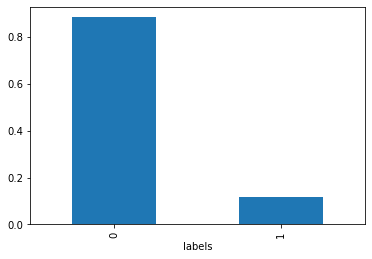

In [10]:
(data.groupby('labels')['labels'].count() / len(data)).plot.bar()


# Identify data Types

In [11]:
# make list of variables  types
dates = [var for var in data.columns if 'Date' in var or 'Year' in var]


# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='label' and 2< data[var].nunique()<20 and var not in dates]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='label' and var not in discrete and var not in dates]
binary_num = [var for var in data.columns if data[var].nunique()==2 and  data[var].dtype!='O' and var!='label']
binary_cat = [var for var in data.columns if data[var].nunique()==2 and  data[var].dtype=='O' and var!='label']
# mixed
mixed = []

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var!='label' and var not in mixed and var not in binary_cat and var not in binary_num]

print('There are {} date variables'.format(len(dates)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} binary categorical variables'.format(len(binary_cat)))
print('There are {} binary numeric variables'.format(len(binary_num)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))


There are 0 date variables
There are 6 discrete variables
There are 0 binary categorical variables
There are 4 binary numeric variables
There are 11 continuous variables
There are 0 categorical variables
There are 0 mixed variables


In [12]:
continuous

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_10',
 'feature_11',
 'feature_12',
 'labels']

In [13]:
dates

[]

In [14]:
discrete

['feature_7',
 'feature_8',
 'feature_9',
 'feature_13',
 'feature_14',
 'feature_15']

In [15]:
binary_cat

[]

In [16]:
binary_num

['feature_10', 'feature_11', 'feature_12', 'labels']

In [17]:
categorical

[]

# Missing Values analisys

In [18]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum()>=1]

# print the variable name and the percentage of missing values
for var in vars_with_na:
    print(var, np.round(data[var].isnull().mean(), 3),  ' % missing values')
    

In [19]:
def analyse_na_value(df, var):
    df = df.copy()

    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's calculate the mean SalePrice where the information is missing or present
    df.groupby(var)['label'].count().plot.bar()
    plt.title(var)
    plt.show()


for var in vars_with_na:
    analyse_na_value(data, var)
    

# Cardinality (number of different categories)

In [20]:
# cardinality (number of different categories)

data[categorical+mixed+discrete].nunique()

feature_7     12
feature_8      3
feature_9      4
feature_13     3
feature_14    12
feature_15     4
dtype: int64

# Distribuition of the Variables - Levels

## Continuous

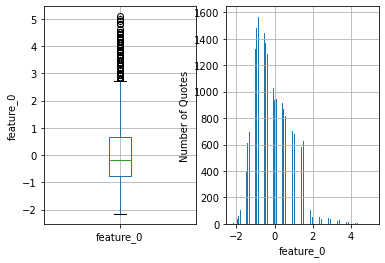

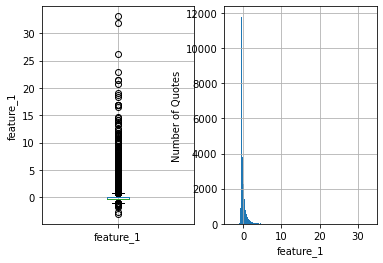

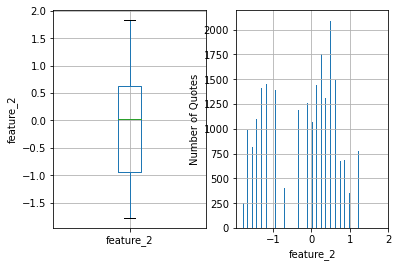

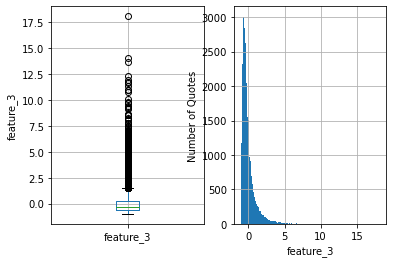

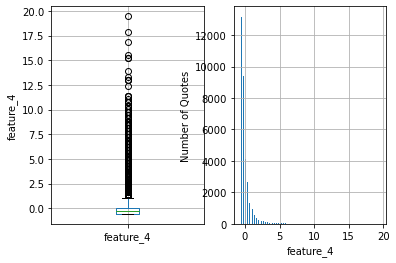

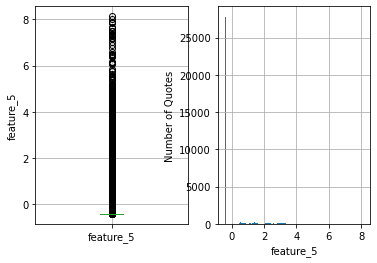

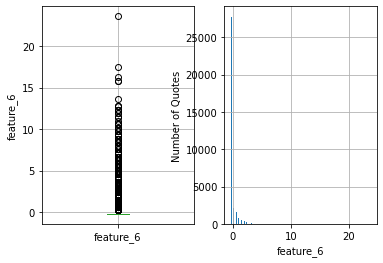

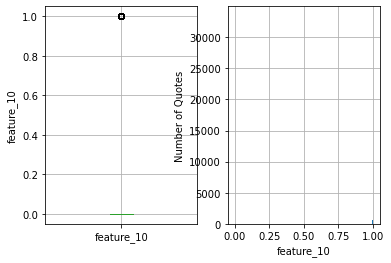

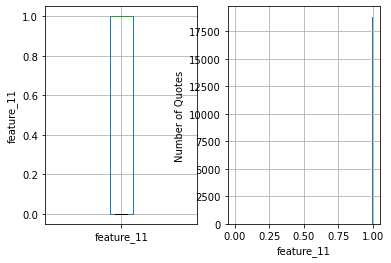

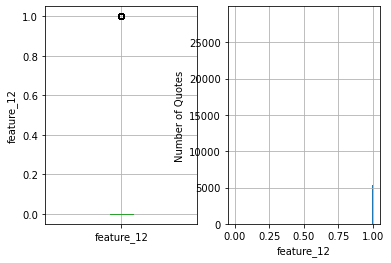

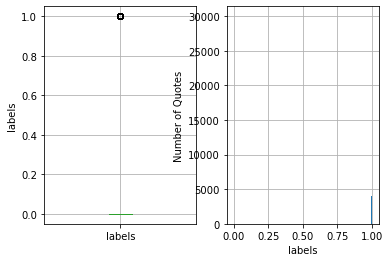

In [21]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=200)
    fig.set_ylabel('Number of Quotes')
    fig.set_xlabel(var)

    plt.show()

## Discrete

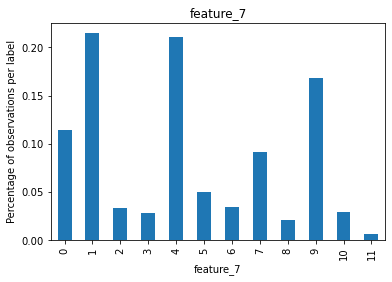

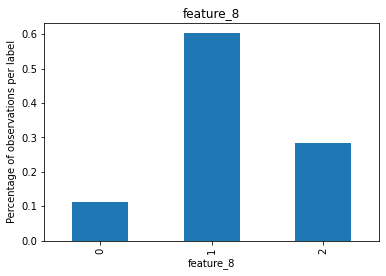

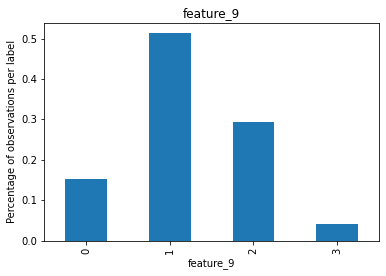

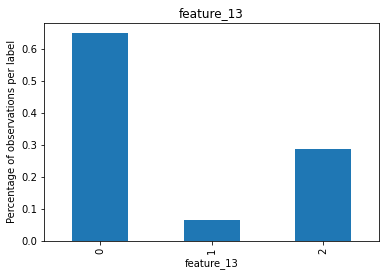

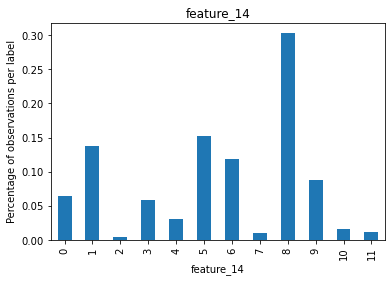

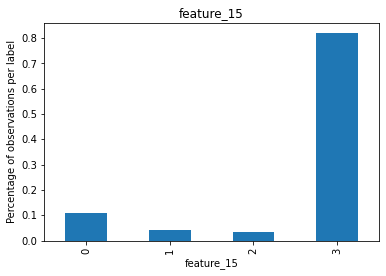

In [22]:
# outliers in discrete variables
for var in discrete+categorical:
    (data.groupby(var)[var].count() / np.float(len(data))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

# Binary data

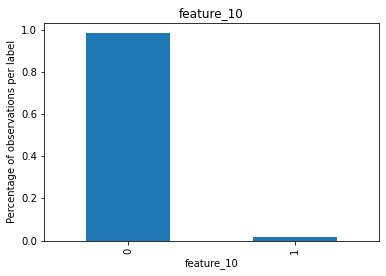

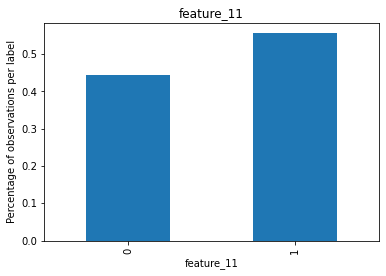

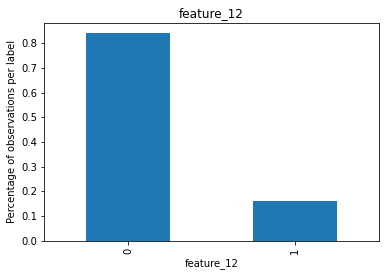

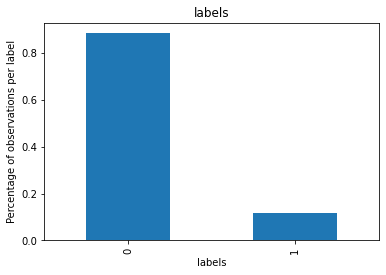

In [23]:
# outliers in discrete variables
for var in binary_num+binary_cat:
    (data.groupby(var)[var].count() / np.float(len(data))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

## Rare Labels

In [24]:
#def analyse_rare_labels(df, var, rare_perc):
#    df = df.copy()
#    tmp = df.groupby(var)['SalePrice'].count() / len(df)
#    return tmp[tmp<rare_perc]

#for var in categorical:
#    print(analyse_rare_labels(data, var, 0.01))
#    print()

In [25]:
#for var in categorical:
#    plt.figure(figsize=(6,4))
#    plt.subplot(1, 2, 1)
#    fig1 = data.groupby([var,'QuoteConversion_Flag']).size().unstack().plot(kind='bar', stacked=True)
#    fig1.set_title('')
#    fig1.set_ylabel(var)
    
#    plt.subplot(1, 2, 2)
#    fig2 = data.groupby([var])['QuoteConversion_Flag'].mean().plot.bar()
    #fig.set_ylabel('% of Conversions')
    #fig.set_xlabel(var)
#    plt.show()

## Split the data

### Get the variables types updated

In [26]:
# make list of variables  types
dates = [var for var in data.columns if 'Date' in var or 'Year' in var]


# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='label' and 2< data[var].nunique()<15 and var not in dates]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='label' and var not in discrete and var not in dates]
binary_num = [var for var in data.columns if data[var].nunique()==2 and  data[var].dtype!='O' and var!='label']
binary_cat = [var for var in data.columns if data[var].nunique()==2 and  data[var].dtype=='O' and var!='label']
# mixed
mixed = []

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var!='label' and var not in mixed and var not in binary_cat and var not in binary_num]

print('There are {} date variables'.format(len(dates)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} binary categorical variables'.format(len(binary_cat)))
print('There are {} binary numeric variables'.format(len(binary_num)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))

There are 0 date variables
There are 6 discrete variables
There are 0 binary categorical variables
There are 4 binary numeric variables
There are 11 continuous variables
There are 0 categorical variables
There are 0 mixed variables


# Separate into train and test set

In [27]:
# Let's separate into train and test set
X_train, X_test, y_train, y_test = train_test_split(data.drop(['labels'], axis=1),
                                                    data['labels'],
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((23735, 16), (10173, 16))

In [28]:
X_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
32360,-0.370689,0.772721,0.503892,-0.979179,4.595294,-0.411453,-0.25194,7,2,0,0,1,0,2,6,3
20382,2.266183,0.268243,-1.418634,-0.567569,1.367391,-0.411453,-0.25194,3,1,0,0,1,0,0,11,3
14911,-1.029906,-0.456287,0.263576,-0.750075,-0.569351,-0.411453,-0.25194,7,1,1,0,1,0,0,5,3
31694,-0.182341,-0.447419,1.585313,-0.287984,-0.246560,-0.411453,-0.25194,4,1,2,0,1,0,2,8,3
8584,0.382703,-0.457272,-1.178318,-0.361763,-0.246560,-0.411453,-0.25194,6,1,1,0,1,1,2,6,3


### Save datasets

In [29]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv(data_folder /'processed/xtrain.csv', index=False, header=True)
X_test.to_csv(data_folder /'processed/xtest.csv', index=False, header=True)

y_train.to_csv(data_folder /'processed/ytrain.csv', index=False, header=True)
y_test.to_csv(data_folder /'processed/ytest.csv', index=False, header=True)

missing inputatio for discrete 

In [30]:
# Rare value encoder
#rare_encoder = RareLabelCategoricalEncoder(
#    tol=0.05,  # minimal percentage to be considered non-rare
#    n_categories=5, # minimal number of categories the variable should have to re-cgroup rare categories
#    variables=categorical # variables to re-group
#)  

In [31]:
#rare_encoder.fit(tmp2)

In [32]:
#rare_encoder.variables

In [33]:
# the encoder_dict_ is a dictionary of variable: frequent labels pair
#rare_encoder.encoder_dict_

In [34]:
#tmp22 = rare_encoder.transform(tmp2)

SAme but with a pipeline

# Build Pipeline

In [35]:
#quote_pipe = Pipeline([
#    # Add missing indicator
#    ('missing_ind_categorical', mdi.AddMissingIndicator(variables=vars_with_na)),
#    # Impute categorical variables with value "Missing"
#    ('imputer_cat_miss',mdi.CategoricalVariableImputer(variables=categorical)),
#    ('imputer_cat_rare',ce.RareLabelCategoricalEncoder(tol=0.05, n_categories=5, variables=categorical)),
#    ('categorical_enc', ce.OneHotCategoricalEncoder(top_categories=None,drop_last=True, variables=categorical+binary_cat)),
#])

In [36]:
#quote_pipe.fit(X_train)

#X_train_transformed = quote_pipe.transform(X_train)
#X_test_transformed = quote_pipe.transform(X_test)
#X_train_transformed.head()

In [37]:
#X_train_transformed.dtypes

### Remove constant features

In [38]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((23735, 16), (10173, 16))

In [39]:
constant_features

[]

### Remove quasi-constant features

In [40]:
# remove quasi-constant features
#sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately

#sel.fit(X_train_transformed)  # fit finds the features with low variance

#sum(sel.get_support()) # how many not quasi-constant?

In [41]:
#features_to_drop = X_train_transformed.columns[[not i for i in sel.get_support() ]]
#features_to_drop

In [42]:
#X_train_transformed.drop(labels=features_to_drop, axis=1, inplace=True)
#X_test_transformed.drop(labels=features_to_drop, axis=1, inplace=True)

#X_train_transformed.head()

### Remove duplicated features

In [43]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            print(f'the values on {col_1} are the same as {col_2}')
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10


0

In [44]:
duplicated_feat = list(dict.fromkeys(duplicated_feat)) #remove duplicates
duplicated_feat

[]

In [45]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((23735, 16), (10173, 16))

### Remove correlated features

In [46]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

current_continuos = intersection(continuous,X_train.columns)
current_continuos

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_10',
 'feature_11',
 'feature_12']

In [47]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train[current_continuos], 0.8)
print('correlated features: ', len(set(corr_features)))

correlated features:  0


In [48]:
X_train[current_continuos].corr()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_10,feature_11,feature_12
feature_0,1.000000,0.095444,-0.008381,-0.007771,-0.004780,-0.017698,0.006190,-0.014126,-0.182369,-0.015491
feature_1,0.095444,1.000000,0.002966,0.022993,-0.022160,0.006466,0.027984,-0.065569,-0.064601,-0.087629
feature_2,-0.008381,0.002966,1.000000,-0.031726,0.169449,-0.095063,-0.057255,0.017362,-0.025937,0.006687
feature_3,-0.007771,0.022993,-0.031726,1.000000,-0.083045,-0.001944,0.001389,-0.010371,0.007416,-0.015780
feature_4,-0.004780,-0.022160,0.169449,-0.083045,1.000000,-0.087716,-0.047243,0.024173,-0.026642,0.007551
feature_5,-0.017698,0.006466,-0.095063,-0.001944,-0.087716,1.000000,0.553643,-0.032199,0.120598,-0.024912
feature_6,0.006190,0.027984,-0.057255,0.001389,-0.047243,0.553643,1.000000,-0.024944,0.035846,-0.011181
feature_10,-0.014126,-0.065569,0.017362,-0.010371,0.024173,-0.032199,-0.024944,1.000000,-0.006259,0.086606
feature_11,-0.182369,-0.064601,-0.025937,0.007416,-0.026642,0.120598,0.035846,-0.006259,1.000000,0.042610
feature_12,-0.015491,-0.087629,0.006687,-0.015780,0.007551,-0.024912,-0.011181,0.086606,0.042610,1.000000


In [49]:
#X_train_transformed.drop(labels=corr_features, axis=1, inplace=True)
#X_test_transformed.drop(labels=corr_features, axis=1, inplace=True)

#X_train_transformed.shape, X_test_transformed.shape

## Random Forest importance

In [50]:
# here I will do the model fitting and feature selection
# altogether in one line of code

# first I specify the Random Forest instance, indicating
# the number of trees

# Then I use the selectFromModel object from sklearn
# to automatically select the features

# SelectFrom model will select those features which importance
# is greater than the mean importance of all the features
# by default, but you can alter this threshold if you want to

sel_ = SelectFromModel(RandomForestClassifier(n_estimators=300),threshold="0.55*mean")
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=300, n_jobs=None,
                                                 oob_score=False,

In [51]:
# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

selected_feat=list(X_train.columns[sel_.get_support()])
selected_feat

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_7',
 'feature_14',
 'feature_15']

In [52]:
# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean importance, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(sel_.estimator_.feature_importances_ > sel_.estimator_.feature_importances_.mean())))

total features: 16
selected features: 9
features with coefficients greater than the mean coefficient: 5


In [53]:
X_train_model=X_train[selected_feat]
X_test_model=X_test[selected_feat]

### Bayesian Optimization

In [54]:
def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )
    
    classifier.fit(X_train_model, y_train)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train_model, y = y_train, cv = 5,scoring='roc_auc')
    CrossValMean = accuracies.mean()

    print("CrossValMean:", CrossValMean)

    return{'loss':1-CrossValMean, 'status': STATUS_OK }


In [55]:

space = {
    'max_depth' : hp.choice('max_depth', range(2, 9, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(100, 600, 25)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            return_argmin=False,
            trials=trials)

print("Best: ", best)


CrossValMean:                                         
0.9139796181421904                                    
CrossValMean:                                                                    
0.9142707141681632                                                               
CrossValMean:                                                                    
0.9128868375934183                                                               
CrossValMean:                                                                    
0.913751535856073                                                                
CrossValMean:                                                                    
0.9051676987162722                                                               
CrossValMean:                                                                    
0.9050009076170962                                                               
CrossValMean:                                                         

In [56]:
best

{'colsample_bytree': 0.78,
 'gamma': 0.33,
 'learning_rate': 0.14,
 'max_depth': 6,
 'min_child_weight': 8.0,
 'n_estimators': 325,
 'subsample': 0.85}

In [57]:
# A method for saving object data to JSON file
def save_json(self, filepath):
    dict_ = {}
    dict_ = self

    # Creat json and save to file
    json_txt = json.dumps(dict_, indent=4)
    with open(filepath, 'w') as file:
        file.write(json_txt)
        
# A method for loading data from JSON file
def load_json(filepath):
    with open(filepath, 'r') as file:
        dict_ = json.load(file)

    return dict_

In [58]:
models_folder = Path("/Users/joaosantos/Documents/Projects/Insurance_Churn/Insurance_Churn/models/")
save_json(best,models_folder/'research_hyperparameters.json')

In [59]:
def create_schema(data, verbose=False):
    schema = {}
    for feature in data.columns:
        if verbose:
            print(f"----- {feature} ----")
            print(f"{data[feature].mean()}")
            print(f"{data[feature].std()}")
            print(f"{data[feature].min()}")
            print(f"{data[feature].max()}")
            print(f"{data[feature].unique()[0:20]}")
            print(f"-----           ----")
        thisdict = {"mean": float(data[feature].mean()),
                    "std": float(data[feature].std()),
                    "min": float(data[feature].min()),
                    "max": float(data[feature].max()),
                    "values": (data[feature].unique()[0:20]).tolist(),
                    "type": str(data[feature].dtypes)
                   }
        schema[feature]=thisdict
    return schema

In [60]:
schema= create_schema(X_train_model)
#schema
save_json(schema,models_folder/'train_schema.json')

In [61]:
best= load_json(models_folder/'research_hyperparameters.json')

In [62]:
best

{'colsample_bytree': 0.78,
 'gamma': 0.33,
 'learning_rate': 0.14,
 'max_depth': 6,
 'min_child_weight': 8.0,
 'n_estimators': 325,
 'subsample': 0.85}

In [63]:
train_schema= load_json(models_folder/'train_schema.json')
train_schema.keys()

dict_keys(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_7', 'feature_14', 'feature_15'])

### Fit Final Model

In [64]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )

classifier.fit(X_train_model, y_train)

# Applying k-Fold Cross Validation  m
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_test_model, y = y_test, cv = 10,scoring='roc_auc')
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()
print("Final CrossValSTD: ", CrossValSTD)

Final CrossValMean:  0.9061529115338681
Final CrossValSTD:  0.01299730516647876


In [65]:
## let's make predictions
X_train_preds_best = classifier.predict_proba(X_train_model,)[:,1]
X_test_preds_best = classifier.predict_proba(X_test_model,)[:,1]

In [66]:
print('Train set')
print('XGB roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds_best)))

print('Test set')
print('XGB roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds_best)))

Train set
XGB roc-auc: 0.9773600712548021
Test set
XGB roc-auc: 0.9167853385659275


### AUC confidence Interval

In [67]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y
        df.loc[:, 'pred'] = pred
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y_test, X_test_preds_best, ["Churn"])

In [68]:
def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df

print_confidence_intervals(["Churn"],statistics)

,Mean AUC (CI 5%-95%)
Churn,0.92 (0.90-0.93)


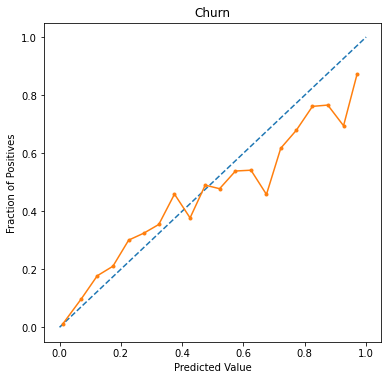

In [69]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred,class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y, pred, n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labels[i])
    plt.tight_layout()
    plt.show()
    
plot_calibration_curve(y_test, X_test_preds_best,["Churn"])

### Calibration with Plat Scaling

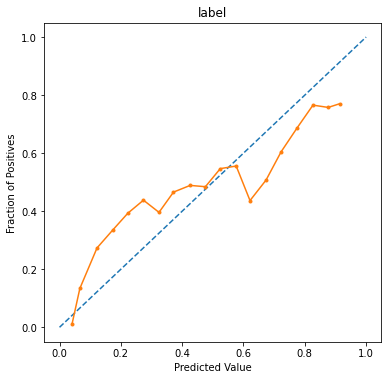

In [70]:
from sklearn.linear_model import LogisticRegression as LR 

pred_calibrated = np.zeros_like(X_test_preds_best)
lr = LR(solver='liblinear', max_iter=10000)
lr.fit(X_test_preds_best.reshape(-1, 1), y_test)    
pred_calibrated = lr.predict_proba(X_test_preds_best.reshape(-1, 1))[:,1]
    

plot_calibration_curve(y_test, pred_calibrated,["label"])

In [71]:
statistics_calib = bootstrap_auc(y_test, pred_calibrated, ["Churn"])
print_confidence_intervals(["Churn"],statistics_calib)

,Mean AUC (CI 5%-95%)
Churn,0.92 (0.90-0.93)


In [72]:
#from sklearn.isotonic import IsotonicRegression as IR

#pred_calibrated = np.zeros_like(X_test_preds)
#ir = IR( out_of_bounds = 'clip' )
#ir.fit( X_test_preds.reshape(-1, 1), y_test)
#p_calibrated = ir.fit(X_test_preds.reshape(-1, 1))[:,1]


### AUC and PR Curves

In [73]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)
def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt, pred)
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt, pred)
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt, pred)
            #avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(gt, pred, average='weighted')
            average_precision = average_precision_score(gt, pred)
            label = target_names[i] + " Avg. Precision: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

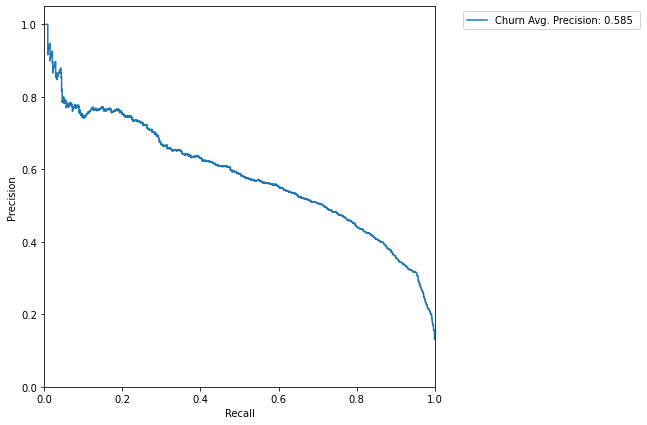

In [74]:
get_curve(y_test, X_test_preds_best,["Churn"], curve='prc')

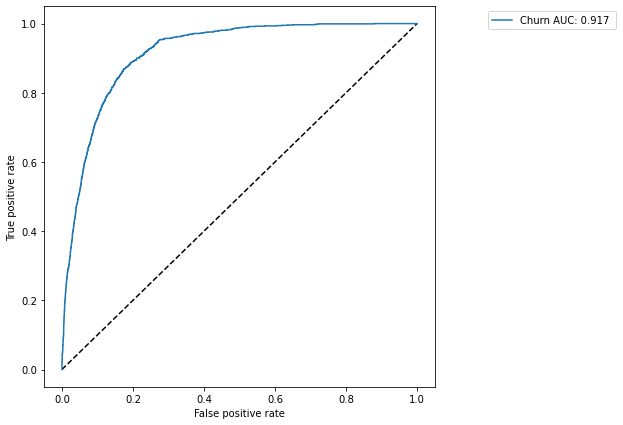

In [75]:
get_curve(y_test, X_test_preds_best,["Churn"], curve='roc')

### Feature Importance

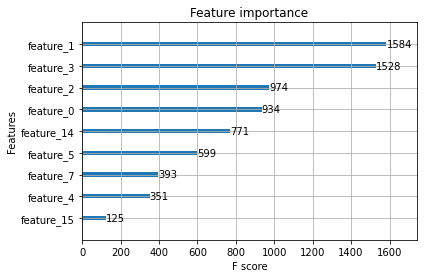

In [76]:
# plot feature importance
plot_importance(classifier)
plt.show()

In [77]:
# plot feature importance
(classifier.feature_importances_ >0).sum()

9

## Model Explanation

### SHAP Values

In [78]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test_model)
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Expected Value: -2.256705


,0,1,2,3,4,5,6,7,8
0,-0.316556,-0.467629,-0.058665,0.855754,-0.440270,-0.398771,-0.239450,-0.159458,0.018278
1,1.222315,0.482535,-0.852857,-1.929906,-0.846300,-0.234230,-0.231691,0.717280,0.100639
2,-0.175615,0.024244,-0.143577,-0.332421,0.406950,-0.270012,-0.051857,0.795896,0.081262
3,0.073870,-0.131554,0.170268,-2.619990,0.172103,0.284037,-0.334792,-1.435890,-0.403543
4,-0.009962,0.095150,0.599842,-0.300273,-0.158029,-0.339576,-0.404400,-0.108901,0.033807


In [79]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_model.iloc[0,:])

In [80]:
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test_model.iloc[:1000,:])

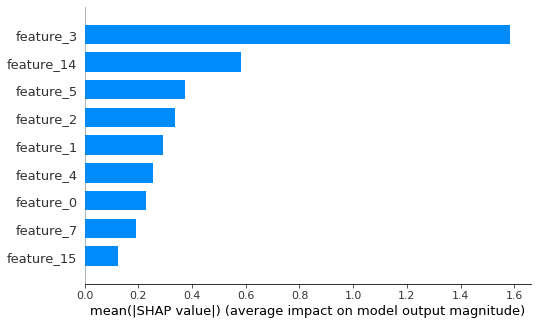

In [81]:
shap.summary_plot(shap_values, 
                  X_test_model, plot_type="bar")

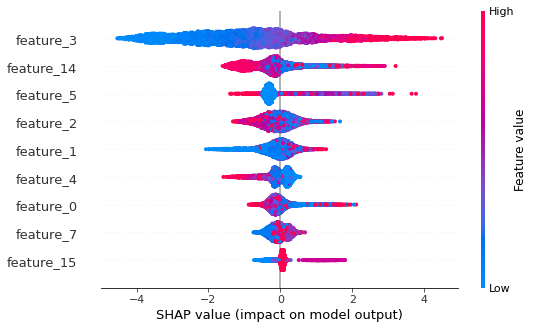

In [82]:
shap.summary_plot(shap_values, X_test_model)

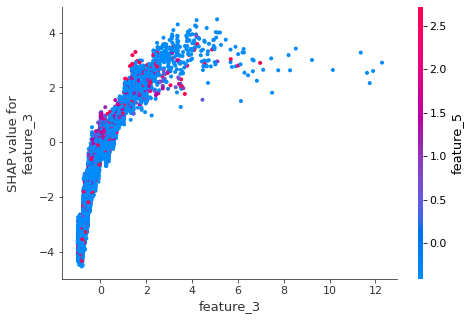

In [83]:
shap.dependence_plot(ind='feature_3', interaction_index='feature_5',
                     shap_values=shap_values, 
                     features=X_test_model,  
                     display_features=X_test_model)

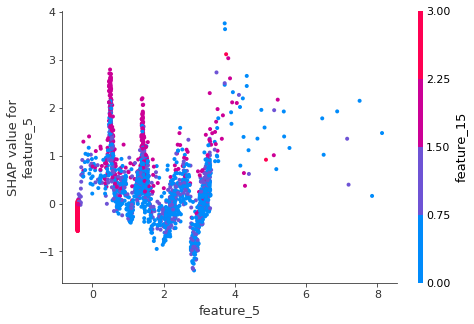

In [84]:
shap.dependence_plot(ind='feature_5', interaction_index='feature_15', 
                     shap_values=shap_values, features=X_test_model, 
                     display_features=X_test_model)

### ELI5

In [85]:
import eli5
eli5.show_weights(classifier.get_booster())

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
Using TensorFlow backend.


Weight,Feature
0.4050,feature_15
0.1442,feature_3
0.1001,feature_14
0.0973,feature_5
0.0572,feature_2
0.0557,feature_0
0.0508,feature_7
0.0478,feature_4
0.0420,feature_1


In [86]:
doc_num = 100

predictions=X_test_preds_best
gt=y_test.values

print('Actual Label:', gt[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(classifier.get_booster(), X_test_model.iloc[doc_num], 
                     feature_names=list(X_test_model.columns),
                     show_feature_values=True)

Actual Label: 0
Predicted Label: 0.12908535


### Save Features

In [87]:
# now we save the selected list of features
pd.Series(selected_feat).to_csv(models_folder /'research_selected_features_classifier.csv', index=False)

### Save seed

# Adding custom transformer for sklearn

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline 

#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

In [89]:
train_schema= load_json(models_folder/'train_schema.json')
features=list(train_schema.keys())

In [90]:
churn_pipe = Pipeline([
    # Add missing indicator
    ('feature_selector',FeatureSelector(features))])

churn_pipe.fit(X_train)

X_train_model = churn_pipe.transform(X_train)
X_test_model = churn_pipe.transform(X_test)
X_train_model.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_7', 'feature_14', 'feature_15'],
      dtype='object')

In [91]:
churn_pipe = Pipeline([
    # Add missing indicator
    ('feature_selector',FeatureSelector(features))])

In [92]:
hyperparameters= load_json(models_folder/'research_hyperparameters.json')
hyperparameters

{'colsample_bytree': 0.78,
 'gamma': 0.33,
 'learning_rate': 0.14,
 'max_depth': 6,
 'min_child_weight': 8.0,
 'n_estimators': 325,
 'subsample': 0.85}

In [93]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators = hyperparameters['n_estimators'],
                            max_depth = hyperparameters['max_depth'],
                            learning_rate = hyperparameters['learning_rate'],
                            gamma = hyperparameters['gamma'],
                            min_child_weight = hyperparameters['min_child_weight'],
                            subsample = hyperparameters['subsample'],
                            colsample_bytree = hyperparameters['colsample_bytree']
                            )

model.fit(X_train_model, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.78, gamma=0.33,
              learning_rate=0.14, max_delta_step=0, max_depth=6,
              min_child_weight=8.0, missing=None, n_estimators=325, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.85, verbosity=1)

In [94]:
from joblib import dump, load
dump(model, models_folder/'research_model_v1.joblib') 

['/Users/joaosantos/Documents/Projects/Insurance_Churn/Insurance_Churn/models/research_model_v1.joblib']

In [95]:
model_up = load(models_folder/'research_model_v1.joblib') 
model_up

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.78, gamma=0.33,
              learning_rate=0.14, max_delta_step=0, max_depth=6,
              min_child_weight=8.0, missing=nan, n_estimators=325, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.85, verbosity=1)

In [96]:
from joblib import dump, load
dump(churn_pipe, models_folder/'research_feature_extractor_v1.joblib') 

['/Users/joaosantos/Documents/Projects/Insurance_Churn/Insurance_Churn/models/research_feature_extractor_v1.joblib']